### file copy

In [ ]:
ict.copy_figs_to_bucket(sc.settings.figdir, fig_dir, 'distplot*')

## initialize

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os, copy
import nbimporter
import inCITE_tools as ict
import anndata
import seaborn as sns
import scvelo as scv
scv.set_figure_params()
bg = ict.make_gray_monoscale_cmap()
seismic_gray = ict.make_seismic_with_nan()

run_folder = '20210414_revision_combined'
samp_dir = 'seq_data/%s' %run_folder
sc.settings.figdir = './analyses/%s' %run_folder
if not os.path.isdir(sc.settings.figdir): os.makedirs(sc.settings.figdir)
fig_dir = 'gs://BUCKET_PATH/10x_analysis/20210414_revision2/figures'

sc.settings.verbosity = 3             
sc.logging.print_versions()
clustered_data = './write/revision_clustered_with_habib_good_inCITE_annot.h5ad'
raw_data = './write/revision_inCITE_raw_isoform_layers.h5ad'

antibodies = ['p65','c-Fos','NeuN','PU.1']

# load files
adata = sc.read(clustered_data)
adata_raw = sc.read(raw_data)
clusters = adata.obs.annot.cat.categories

# data subsets
ad_inCITE = adata[adata.obs['sample_type']=='fixed']

# colors
annot_colors = adata.uns['annot_colors_round1']
annot_to_colors = dict(zip(clusters, annot_colors))

-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.1
-----
PIL                 8.2.0
anndata             0.7.6
attr                20.3.0
backcall            0.2.0
cached_property     1.5.2
cffi                1.14.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
descartes           NA
get_version         2.2
google              NA
h5py                3.2.1
idna                2.10
igraph              0.9.1
inCITE_tools        NA
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
joblib              1.0.1
jsonschema          3.2.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.4
llvmlite            0.36.0
matplotlib          3.4.1
mizani              0.7.3
mpl_toolkits        NA
natsort             7.1.1
nbformat            5.1.2
nbimporter          NA
numba               0.53.1
numexpr             2.7.3
numpy               1.20.2
packaging     

In [2]:
# remove 3001 nuclei and 29 genes that do not have matching RNA velocity isoform counts 
obs_idx = [i for i in adata_raw.obs.index if i in ad_inCITE.obs.index]
missing_nuclei = [i for i in ad_inCITE.obs.index if i not in adata_raw.obs.index]
missing_nuclei_ind = np.in1d(ad_inCITE.obs_names, missing_nuclei)
print(sum(missing_nuclei_ind))

ad_inCITE = ad_inCITE[~missing_nuclei_ind,:]

obs_idx = [i for i in adata_raw.obs.index if i in ad_inCITE.obs.index]

var_idx = [v for v in adata_raw.var.index if v in ad_inCITE.var.index]
missing_genes = [i for i in ad_inCITE.var.index if i not in adata_raw.var.index]
missing_genes_ind = np.in1d(ad_inCITE.var_names, missing_genes)
print(sum(missing_genes_ind))

ad_inCITE = ad_inCITE[:,~missing_genes_ind]

var_idx = [v for v in adata_raw.var.index if v in ad_inCITE.var.index]

3001
29


In [3]:
# add spliced and unspliced counts as layers
from scipy.sparse import csr_matrix

ad_inCITE.layers['spliced'] = csr_matrix(adata_raw[obs_idx,var_idx].layers['spliced'].toarray(), dtype=np.float64)
ad_inCITE.layers['unspliced'] = csr_matrix(adata_raw[obs_idx,var_idx].layers['unspliced'].toarray(), dtype=np.float64)

# log norm spliced and unspliced layers
sc.pp.normalize_total(ad_inCITE, layers=['spliced','unspliced'])
sc.pp.log1p(ad_inCITE, layer='spliced')
sc.pp.log1p(ad_inCITE, layer='unspliced')
ad_inCITE.layers['spliced_counts'] = ad_inCITE.layers['spliced'].copy()
ad_inCITE.layers['unspliced_counts'] = ad_inCITE.layers['unspliced'].copy()
sc.pp.scale(ad_inCITE, layer='spliced', max_value=10)
sc.pp.scale(ad_inCITE, layer='unspliced', max_value=10)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [4]:
# subset data
ad_iC_PBS = ad_inCITE[ad_inCITE.obs['assignment']=='PBS']
ad_iC_KA = ad_inCITE[ad_inCITE.obs['assignment']=='KainicAcid']

# shuffle rows for plotting only adata object
ad_inCITE_plot = sc.pp.subsample(ad_inCITE, fraction=1, copy=True)

## Protein levels overlayed on UMAP embedding of RNA-based clusters

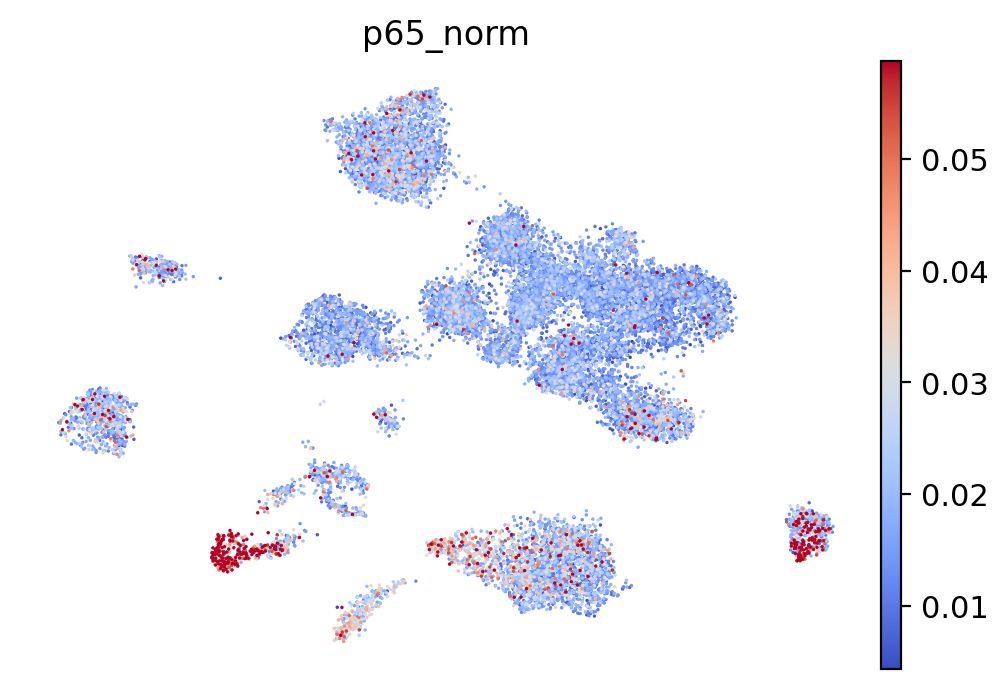

In [5]:
sc.pl.umap(ad_inCITE_plot, color=['p65_norm'], vmin='p2',vmax='p98', cmap='coolwarm', 
           frameon=False, save='_p65_nADT')

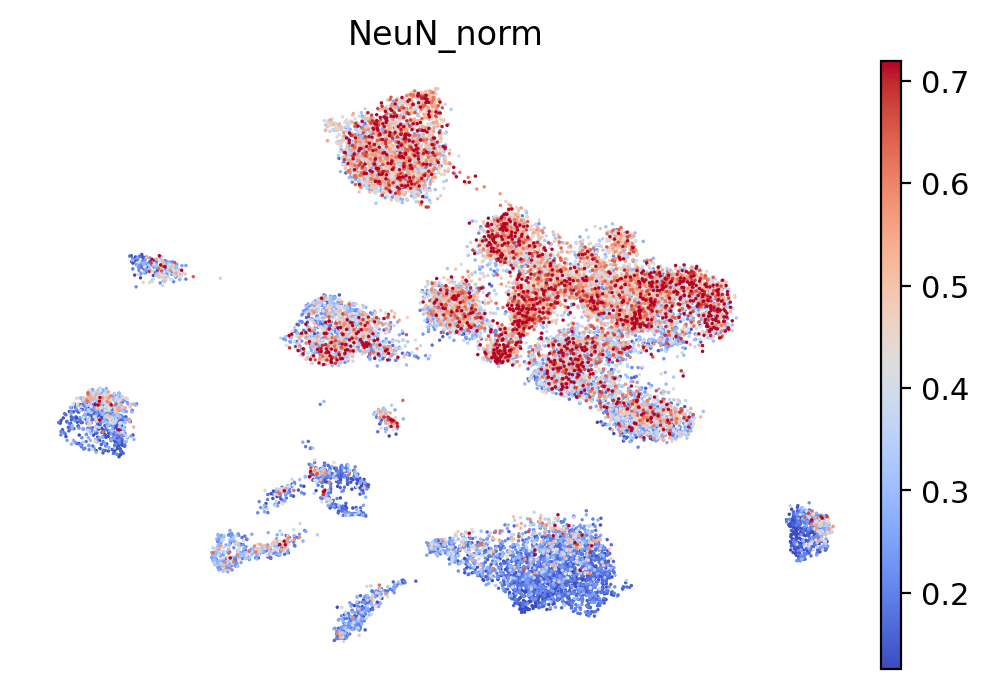

In [6]:
sc.pl.umap(ad_inCITE_plot, color=['NeuN_norm'], vmin='p5',vmax='p95', cmap='coolwarm', 
           frameon=False, save='_NeuN_nADT')

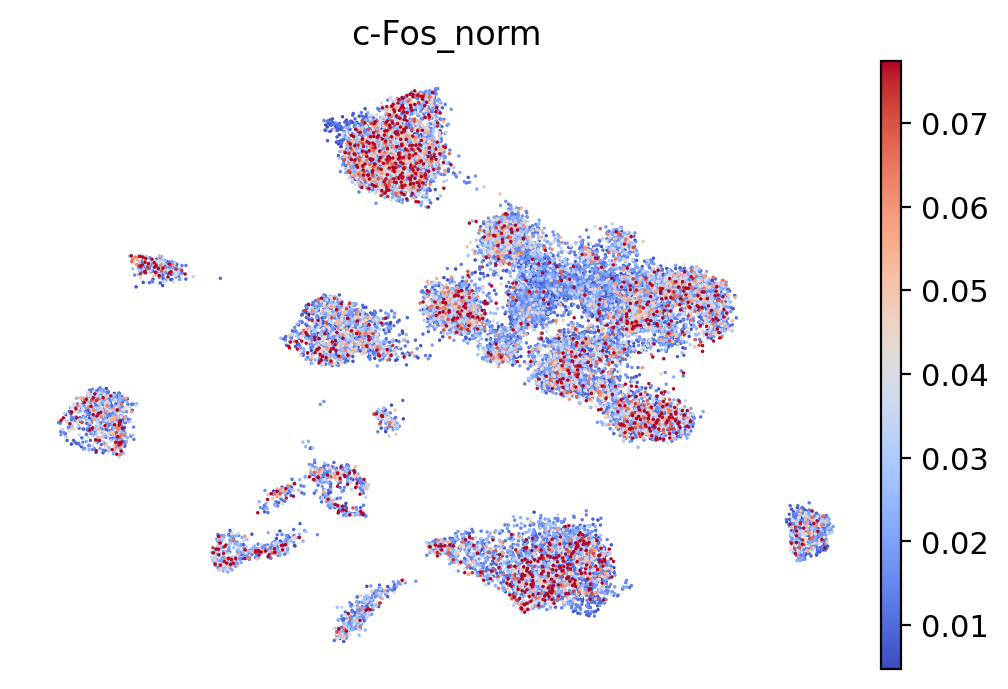

In [7]:
sc.pl.umap(ad_inCITE_plot, color=['c-Fos_norm'], vmin='p5',vmax='p95', cmap='coolwarm', 
           frameon=False, save='_cFos_nADT')

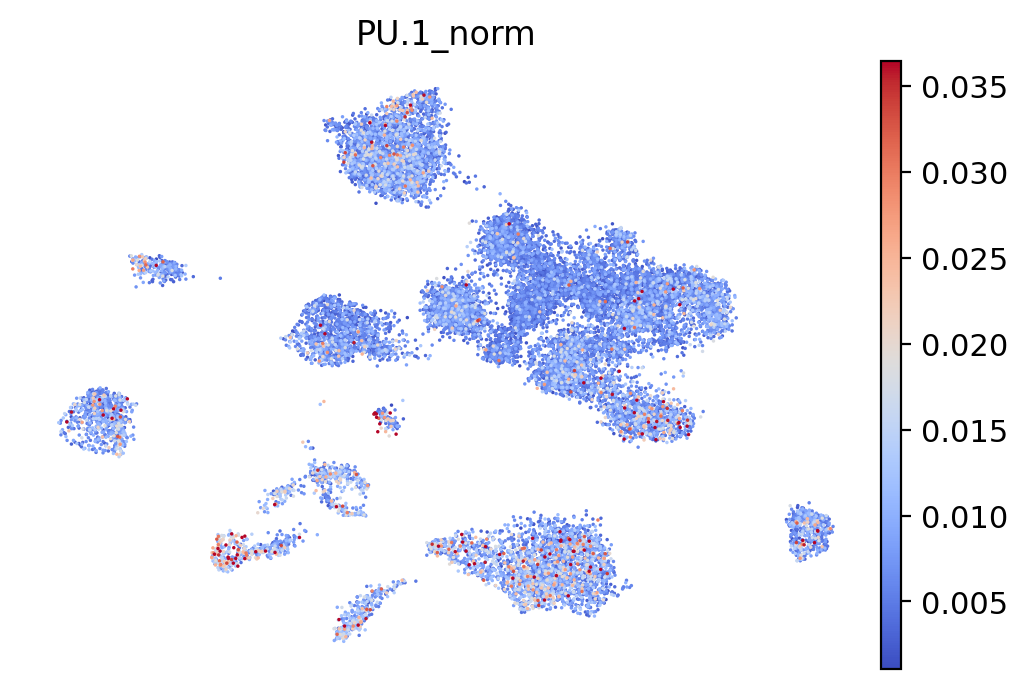

In [8]:
sc.pl.umap(ad_inCITE_plot, color=['PU.1_norm'], vmin='p0.5',vmax='p99.5', cmap='coolwarm', 
           frameon=False, save='_PU1_nADT')

## make adata subsets

In [5]:
def separate_PBS_KA(ad): 
    ad_PBS = ad[ad.obs['assignment']=='PBS'].copy()
    ad_KA = ad[ad.obs['assignment']=='KainicAcid'].copy()
    return ad_PBS, ad_KA

In [6]:
neurons = [cluster for cluster in clusters if cluster.startswith('Ex.')]
neurons.append('GABAergic')

ex_neurons = [cluster for cluster in clusters if cluster.startswith('Ex.')]

glia = ['Astrocyte','Oligodendrocyte','Microglia','OPC']
non_neurons = [ 'Astrocyte',
               'ChoroidPlexus',
                'Oligodendrocyte',
                'OPC',
                'Microglia',
                'NPC',
                'Endothelium',
                'Fibroblast',
                'Pericytes']

ad_PBS, ad_KA = separate_PBS_KA(ad_inCITE)

ad_neuron = ad_inCITE[ad_inCITE.obs['annot'].isin(neurons)]
ad_neur_PBS, ad_neur_KA = separate_PBS_KA(ad_neuron)

ad_ex_neuron = ad_inCITE[ad_inCITE.obs['annot'].isin(ex_neurons)]

ad_non_neur = ad_inCITE[~ad_inCITE.obs['annot'].isin(neurons)]
ad_non_neur_PBS, ad_non_neur_KA = separate_PBS_KA(ad_non_neur)

ad_glia = ad_inCITE[ad_inCITE.obs['annot'].isin(glia)]
ad_glia_PBS, ad_glia_KA = separate_PBS_KA(ad_glia)

ad_DG = ad_inCITE[ad_inCITE.obs['annot'].isin([clust for clust in clusters if clust.startswith('Ex.Granule')])]
ad_DG_PBS, ad_DG_KA = separate_PBS_KA(ad_DG)

ad_CA = ad_inCITE[ad_inCITE.obs['annot'].isin([clust for clust in clusters if clust.startswith('Ex.CA')])]
ad_CA_PBS, ad_CA_KA = separate_PBS_KA(ad_CA)

ad_IN = ad_inCITE[ad_inCITE.obs['annot'].isin(['GABAergic'])]
ad_IN_PBS, ad_IN_KA = separate_PBS_KA(ad_IN)

ad_non_neuron = ad_inCITE[ad_inCITE.obs['annot'].isin(non_neurons)]
ad_non_neur_PBS, ad_non_neur_KA = separate_PBS_KA(ad_non_neuron)

ad_endo = ad_inCITE[ad_inCITE.obs['annot'].isin(['Endothelium'])]
ad_endo_PBS, ad_endo_KA = separate_PBS_KA(ad_endo)

ad_mig = ad_inCITE[ad_inCITE.obs['annot'].isin(['Microglia'])]
ad_mig_PBS, ad_mig_KA = separate_PBS_KA(ad_mig)

ad_CP = ad_inCITE[ad_inCITE.obs['annot'].isin(['ChoroidPlexus'])]
ad_CP_PBS, ad_CP_KA = separate_PBS_KA(ad_CP)

ad_ast = ad_inCITE[ad_inCITE.obs['annot'].isin(['Astrocyte'])]
ad_ast_PBS, ad_ast_KA = separate_PBS_KA(ad_ast)

ad_olig = ad_inCITE[ad_inCITE.obs['annot'].isin(['Oligodendrocyte'])]
ad_olig_PBS, ad_olig_KA = separate_PBS_KA(ad_olig)

ad_NSC = ad_inCITE[ad_inCITE.obs['annot'].isin(['NPC'])]
ad_NSC_PBS, ad_NSC_KA = separate_PBS_KA(ad_NSC)

## Protein nCLR histograms: compare foreground + background by batch

Saving to analyses/20210414_revision_combined/distplot_NeuN_nCLR_by_batch.pdf


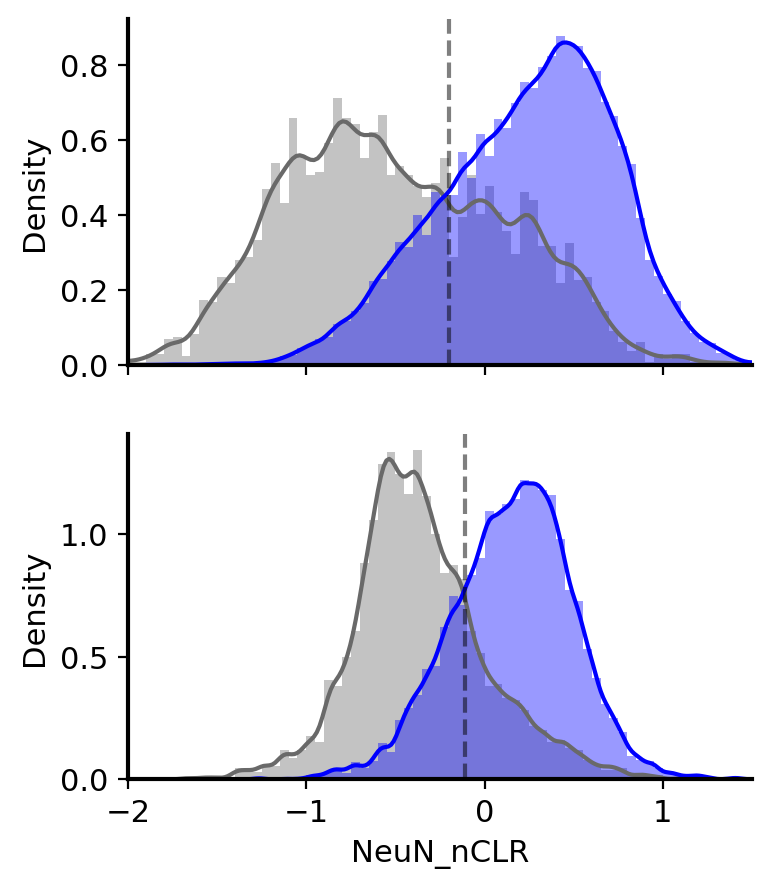

In [11]:
ict.plot_disthist_by_batch('NeuN_nCLR', ad_neuron, 'b', ad_non_neur, '#696969', 
                           savefig=True, dotted_line=True)

0.0 -60.023212564839554


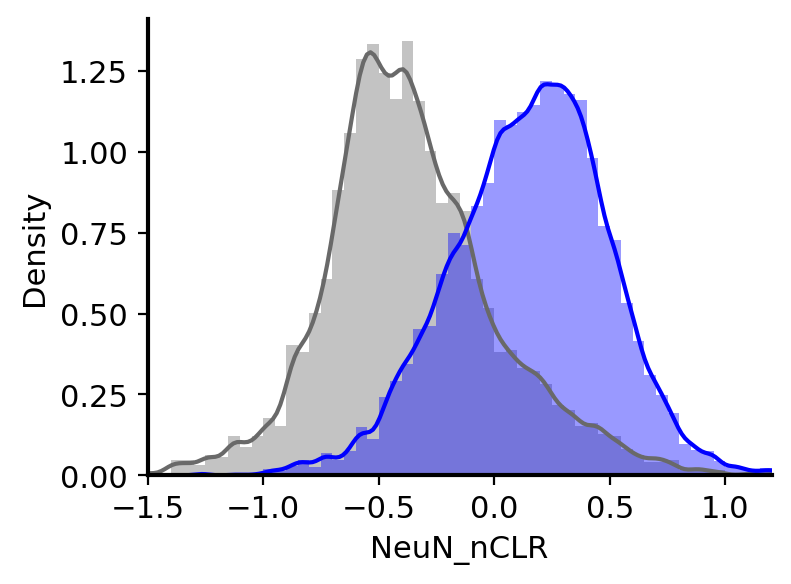

In [12]:
ict.plot_disthist_single_batch('NeuN_nCLR', ad_neuron, 'b', ad_non_neur, '#696969', 
                           '1', xlims=[-1.5,1.2], vertline=False, savefig=True)

Saving to analyses/20210414_revision_combined/distplot_p65_nCLR_by_batch.pdf


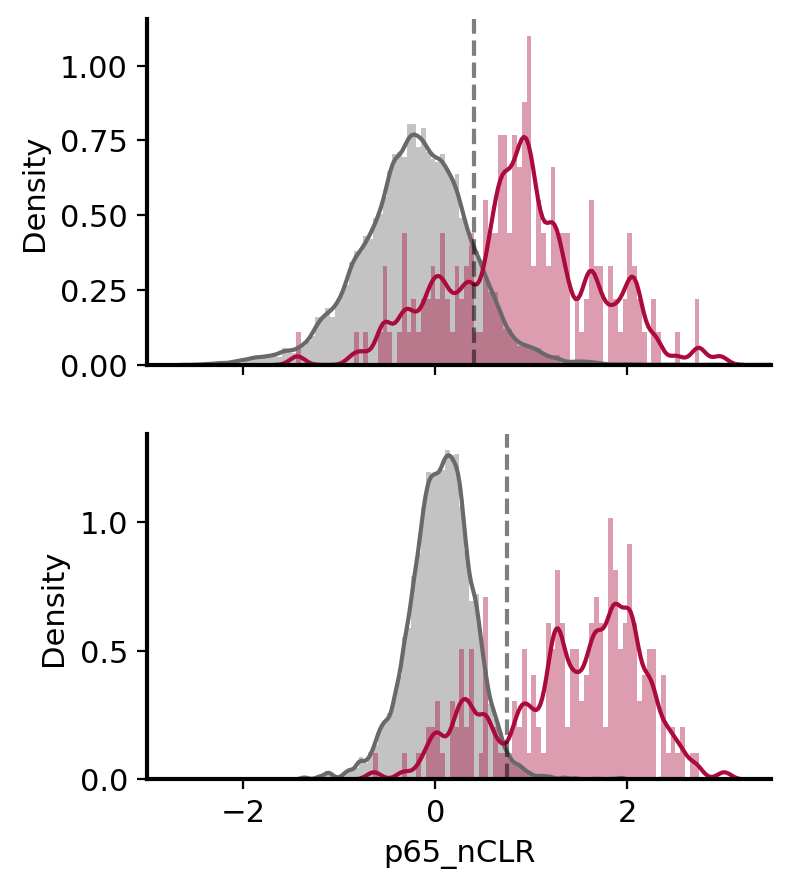

In [13]:
ict.plot_disthist_by_batch('p65_nCLR', ad_endo, '#AA0A3C', ad_neuron, '#696969', 
                           savefig=True, dotted_line=True)

0.0 -51.33235729624769


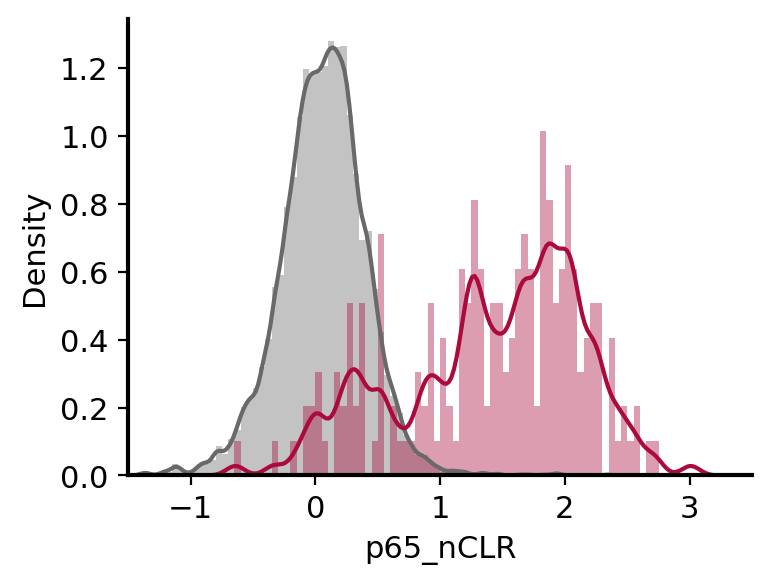

In [14]:
ict.plot_disthist_single_batch('p65_nCLR', ad_endo, '#AA0A3C', ad_neuron, '#696969', 
                              '1', xlims=[-1.5,3.5], savefig=True, vertline=False,
                               figstr='distplot_p65_nCLR_batch1_endothelium')

Saving to analyses/20210414_revision_combined/distplot_PU1_nCLR_by_batch.pdf


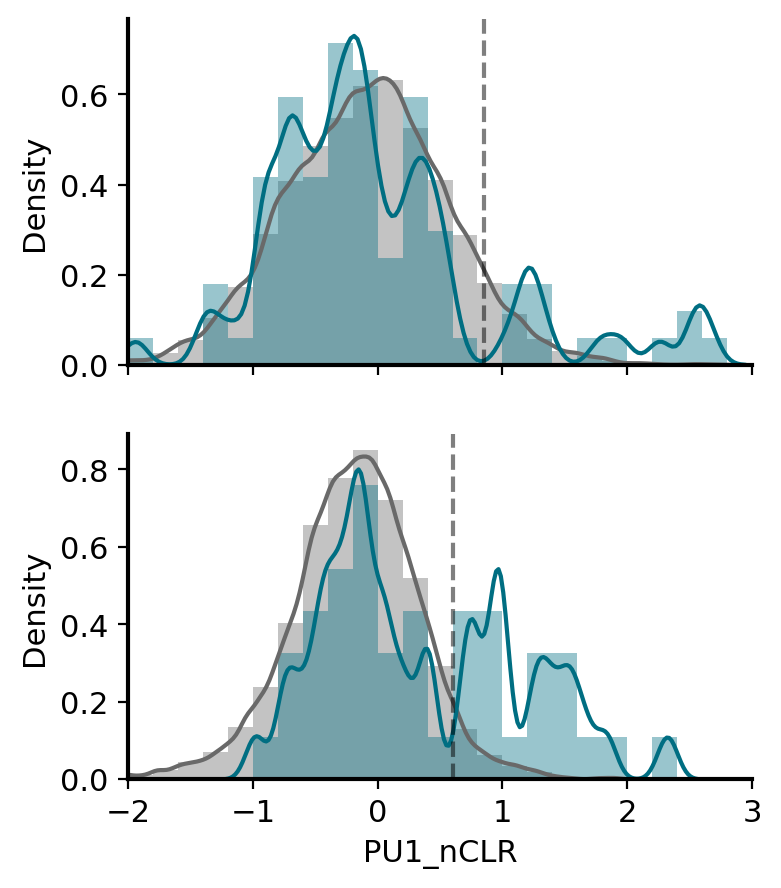

In [15]:
ict.plot_disthist_by_batch('PU1_nCLR', ad_mig, '#006E82', ad_neuron, '#696969', 
                           savefig=True, dotted_line=True)

1.4896731488471363e-12 -7.092179464541792


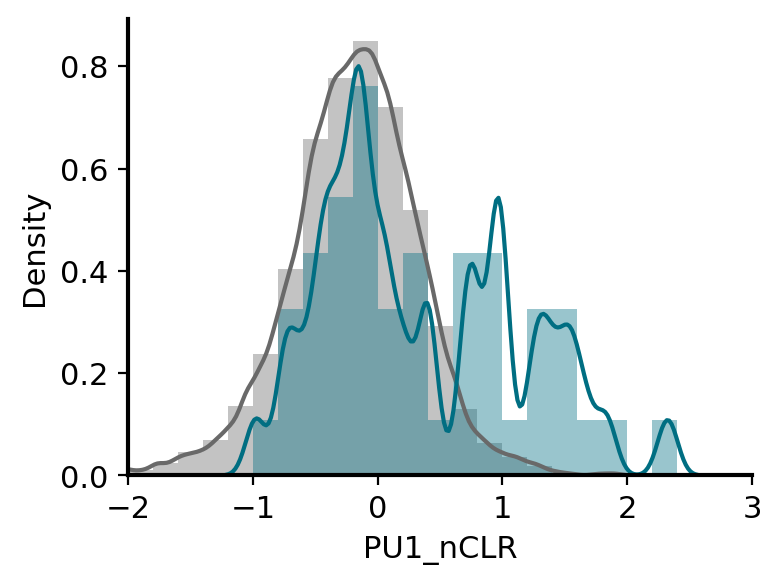

In [13]:
ict.plot_disthist_single_batch('PU1_nCLR', ad_mig, '#006E82', ad_neuron, '#696969', 
                              '1', xlims=[-2,3], 
                               savefig=True, vertline=False,
                               figstr='distplot_PU1_nCLR_batch1_microglia')

Saving to analyses/20210414_revision_combined/distplot_cFos_nCLR_by_batch.pdf


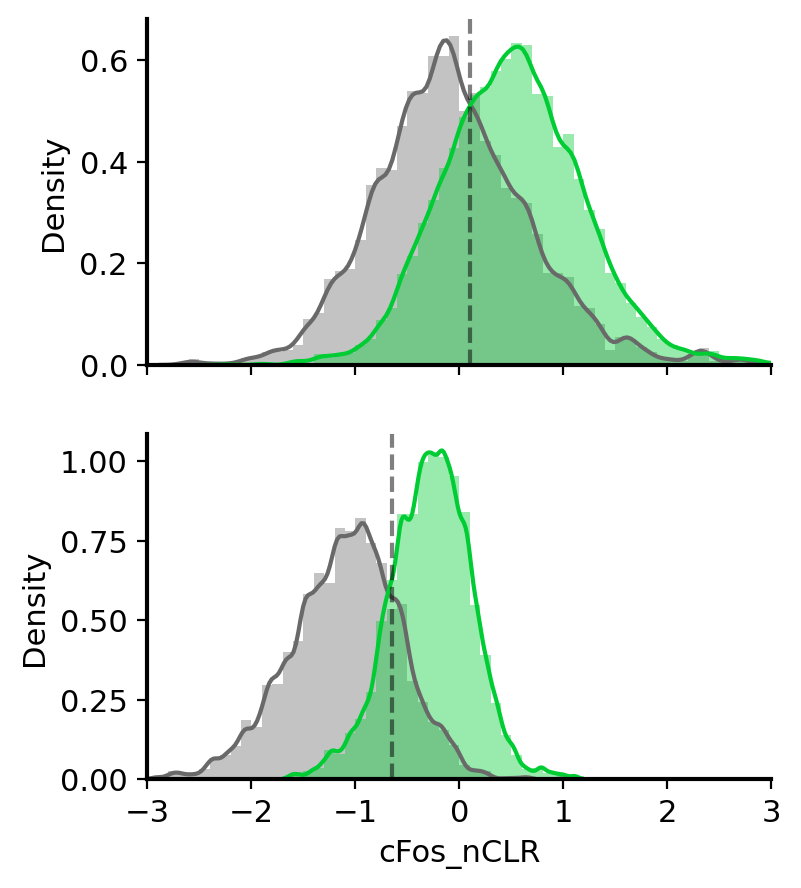

In [17]:
ict.plot_disthist_by_batch('cFos_nCLR', ad_neur_KA, '#00cc33', ad_neur_PBS, '#696969', 
                           savefig=True, dotted_line=True)

0.0 -64.96539035689214


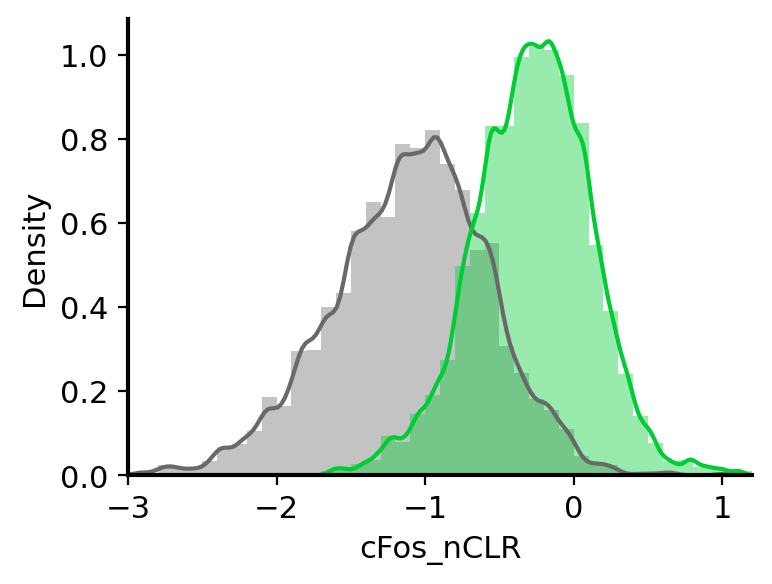

In [18]:
ict.plot_disthist_single_batch('cFos_nCLR', ad_neur_KA, '#00cc33', ad_neur_PBS, '#696969', 
                           '1', xlims=[-3,1.2], vertline=False, savefig=True)

3.2739425679330726e-09 -5.945126274710382


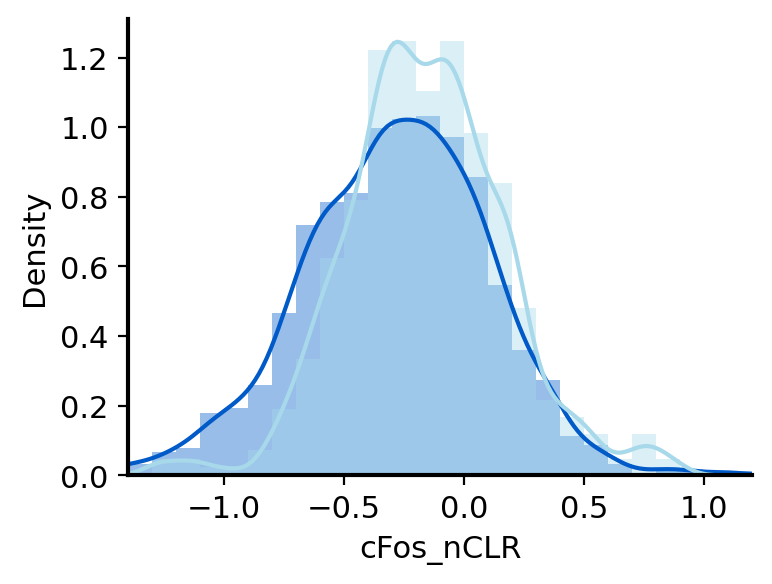

In [19]:
ict.plot_disthist_single_batch('cFos_nCLR', 
                               ad_DG_KA, '#A7D9EA', #annot_to_colors['Ex.GranuleCell'], 
                               ad_CA_KA, annot_to_colors['Ex.CA1.2'], 
                               '1', xlims=[-1.4,1.2], 
                               savefig=True, vertline=False,
                               kde_bw=0.2,
                              figstr='distplot_batch_1_cFos_nCLR_DG_vs_CA_KainicAcid')

0.027967135583214307 -2.202460571096071


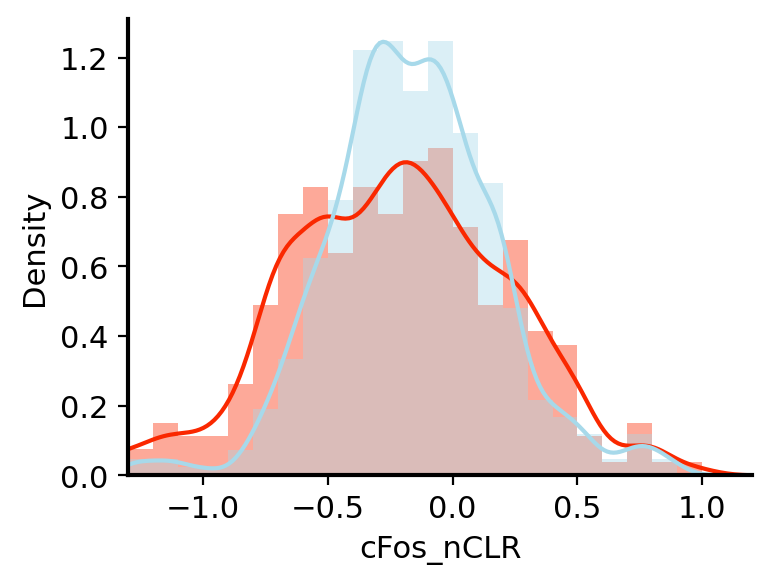

In [20]:
ict.plot_disthist_single_batch('cFos_nCLR', ad_DG_KA, '#A7D9EA', #annot_to_colors['Ex.GranuleCell'],
                               ad_IN_KA, annot_to_colors['GABAergic'],
                               '1', xlims=[-1.3,1.2], 
                               savefig=True, vertline=False,
                               kde_bw=0.2,
                           figstr='distplot_batch_1_cFos_nCLR_DG_vs_IN_KainicAcid')

0.026488774636627018 -2.220831132013743


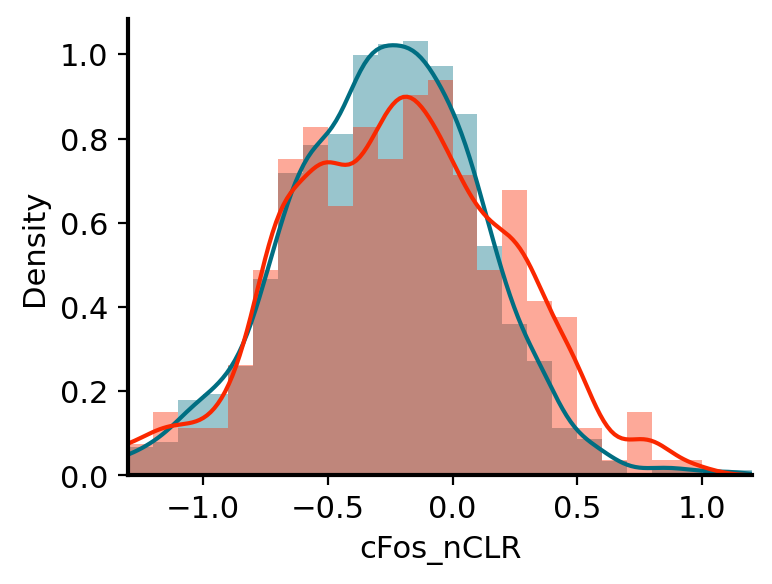

In [21]:
ict.plot_disthist_single_batch('cFos_nCLR', ad_IN_KA, annot_to_colors['GABAergic'],
                               ad_CA_KA, annot_to_colors['Ex.CA1.1'],
                               '1', xlims=[-1.3,1.2], 
                               savefig=True, vertline=False,
                               kde_bw=0.2,
                           figstr='distplot_batch_1_cFos_nCLR_IN_vs_CA_KainicAcid')

0.17794970071325245 1.3472715787990044


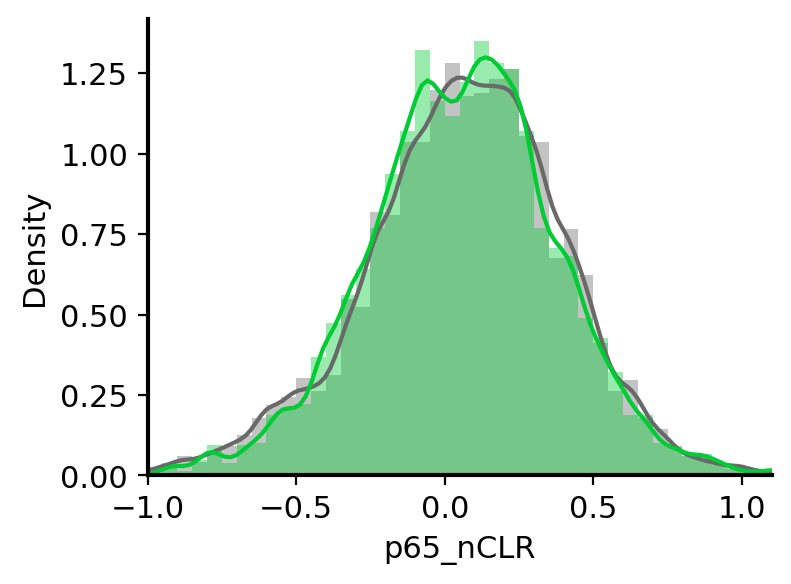

In [22]:
ict.plot_disthist_single_batch('p65_nCLR', ad_neur_KA, '#00cc33', ad_neur_PBS, '#696969', 
                           '1', xlims=[-1,1.1], savefig=True, vertline=False, 
                               figstr='distplot_p65_nCLR_batch1_neurons_KA_vs_PBS')

## Compare batch specific differences in HTOs, c-Fos, ADTs

In [23]:
def plot_raw_CITE_counts_by_batch(ad, feat): 
    in_0 = ad[ad.obs['batch']=='0']
    in_1 = ad[ad.obs['batch']=='1']
    
    if feat=='hashtag_counts': 
        bins = np.arange(0,4000,100)
    elif feat=='c-Fos': 
        bins = np.arange(0,70,1)
    elif feat=='NeuN': 
        bins = np.arange(0,2000,20)
    elif feat=='p65': 
        bins = np.arange(0,100,1)
    elif feat=='PU.1': 
        bins = np.arange(0,30,1)
        
    fig = plt.figure(figsize=(3,3))
    a = plt.hist(in_0.obs[feat], bins=bins, alpha=0.5, density=True, color='#090909')
    b = plt.hist(in_1.obs[feat], bins=bins, alpha=0.6, density=True, color='#79ADE5')
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    if feat=='hashtag_counts': 
        axes.set_xlabel('Hashtag counts (HTOs)', fontsize=14)
    else: 
        axes.set_xlabel('%s ADTs' %feat, fontsize=14)
    axes.set_ylabel('Density', fontsize=14)
    
    figstr = '%s/raw_CITE_counts_by_batch_%s.pdf' %(sc.settings.figdir, feat)
    fig.savefig(figstr, bbox_inches='tight')
    
    print('Saved to %s' %figstr)
    

Saved to analyses/20210414_revision_combined/raw_CITE_counts_by_batch_hashtag_counts.pdf
Saved to analyses/20210414_revision_combined/raw_CITE_counts_by_batch_NeuN.pdf
Saved to analyses/20210414_revision_combined/raw_CITE_counts_by_batch_c-Fos.pdf
Saved to analyses/20210414_revision_combined/raw_CITE_counts_by_batch_p65.pdf
Saved to analyses/20210414_revision_combined/raw_CITE_counts_by_batch_PU.1.pdf


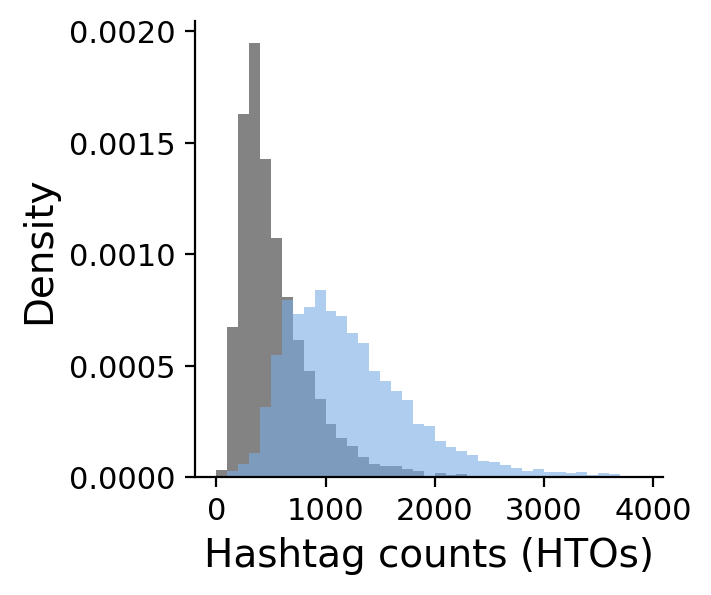

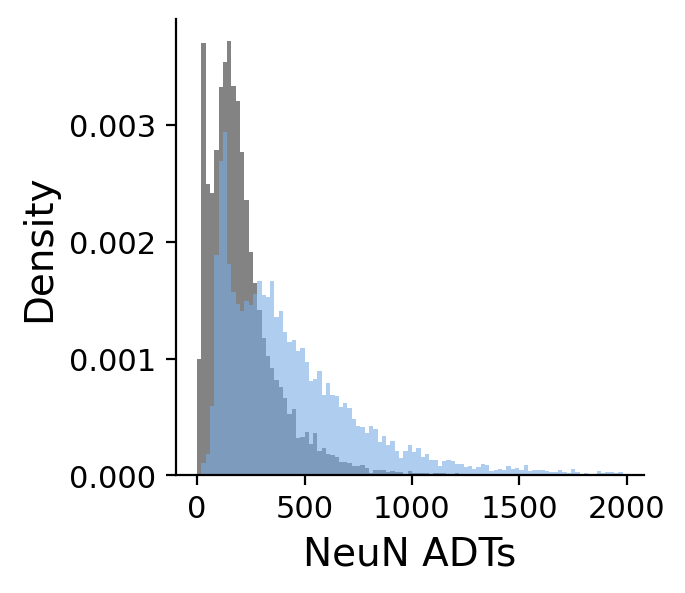

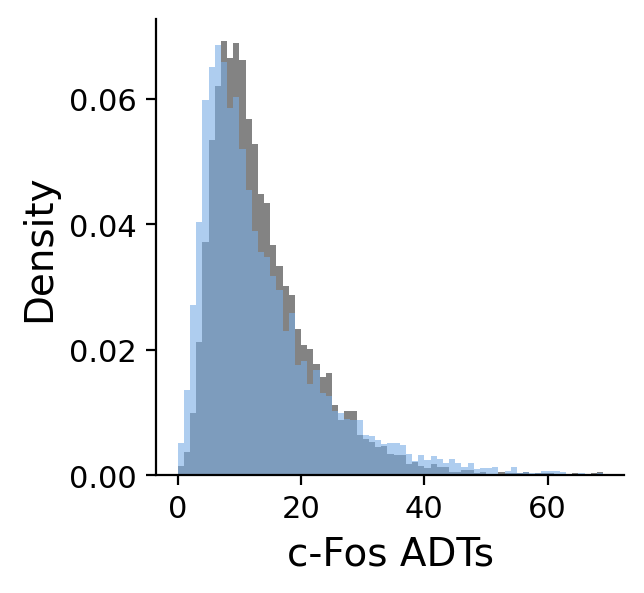

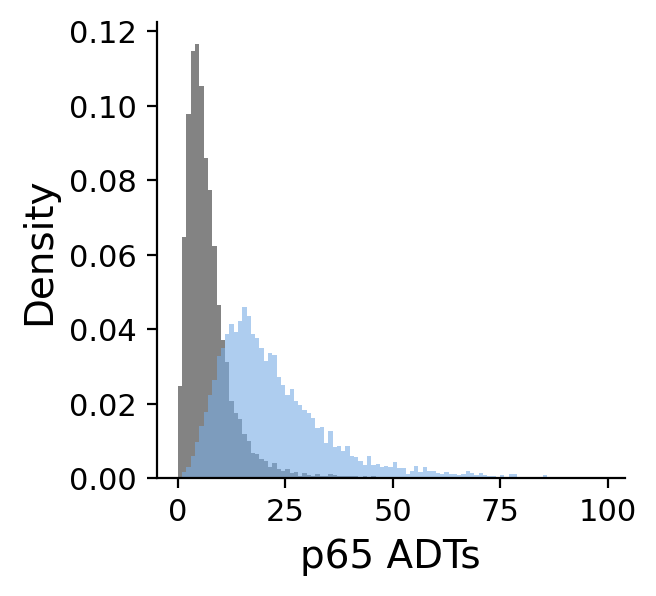

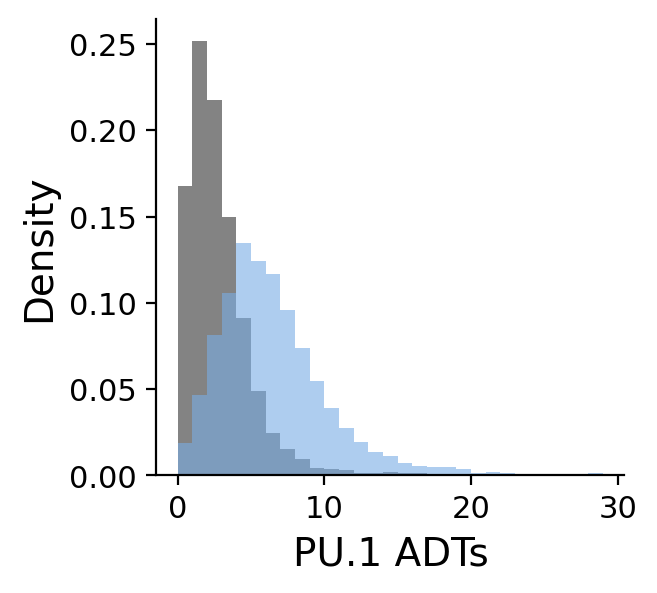

In [24]:
plot_raw_CITE_counts_by_batch(ad_inCITE, 'hashtag_counts')
plot_raw_CITE_counts_by_batch(ad_inCITE, 'NeuN')
plot_raw_CITE_counts_by_batch(ad_inCITE, 'c-Fos')
plot_raw_CITE_counts_by_batch(ad_inCITE, 'p65')
plot_raw_CITE_counts_by_batch(ad_inCITE, 'PU.1')

## Partition cells by protein levels into binary categories

In [25]:
_,_,thresh = ict.get_ab_lims('cFos_nCLR')
ict.CITE_binarize_by_batch(ad_inCITE, 'cFos', 'nCLR', thresh)
ict.CITE_binarize_by_batch(ad_neuron, 'cFos', 'nCLR', thresh)

Trying to set attribute `.obs` of view, copying.


In [26]:
_,_,thresh = ict.get_ab_lims('p65_nCLR')
ict.CITE_binarize_by_batch(ad_inCITE, 'p65', 'nCLR', thresh)
ict.CITE_binarize_by_batch(ad_neuron, 'p65', 'nCLR', thresh)

In [27]:
_,_,thresh = ict.get_ab_lims('NeuN_nCLR')
ict.CITE_binarize_by_batch(ad_inCITE, 'NeuN', 'nCLR', thresh)

In [28]:
def boxplot_RNA_by_treatment(ad_PBS, ad_KA, gene, prot, color_dict='', desc='', 
                             ylims=[0,13], scaling='zscore', remove_zeros=True):
    from statannot import add_stat_annotation
        
    if prot+'_binary' not in ad_PBS.obs.columns: 
        _,_,thresh = ict.get_ab_lims(prot+'_nCLR')
        ict.CITE_binarize_by_batch(ad_PBS, prot, 'nCLR', thresh)
        ict.CITE_binarize_by_batch(ad_KA, prot, 'nCLR', thresh)
    
    _, _, RNA_df_PBS = ict.get_RNA_level_by_protein_bin(ad_PBS, gene, prot,
                                                        scaling=scaling, 
                                                        remove_zeros=remove_zeros)
    _, _, RNA_df_KA = ict.get_RNA_level_by_protein_bin(ad_KA, gene, prot,
                                                        scaling=scaling, 
                                                        remove_zeros=remove_zeros)
    RNA_df_PBS['treatment'] = 'PBS'
    RNA_df_KA['treatment'] = 'KA'
    RNA_joint = RNA_df_PBS.append(RNA_df_KA)
    
    fig, ax = plt.subplots(figsize=(2,3))
    ax = sns.boxplot(data=RNA_joint, x='protein', y=gene, 
                     hue='treatment',
                     hue_order = ['PBS','KA'],
                     width=0.7,
                     linewidth=1,
                     fliersize=0,
                     palette=color_dict)
    ax.set_ylim(ylims)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
#         patch.set_facecolor('white')
        patch.set_facecolor((r, g, b, 0.3))
#         patch.set_edgecolor((r, g, b, 0.7))
        
    ax = sns.stripplot(data=RNA_joint, x='protein', y=gene, 
                       hue='treatment',dodge=True,
                       hue_order = ['PBS','KA'],
                       s=2,
                       alpha=0.8, jitter=0.1,
                       palette=color_dict)
    ax.legend_.remove()
    ax.set(xlabel=None)
    ax.set(xticklabels=[])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    test_results = add_stat_annotation(ax, data=RNA_joint, 
                                       x='protein', y=gene, 
                                       hue='treatment', 
                                       box_pairs=[(("off","PBS"), ("on","PBS")),
                                                  (("off","PBS"), ("off","KA")),
                                                  (("off","KA"), ("on","KA")),
                                                  (("on","PBS"), ("on","KA"))
                                                 ],
                                       test='Mann-Whitney', text_format='star',
                                       loc='outside', verbose=2)
    figname = '%s/boxplot_PBSvsKA_%s_%s_%s_%s.pdf' %(sc.settings.figdir, prot, gene, scaling, desc)
    print('Saved figure to %s' %figname)
    fig.savefig(figname, bbox_inches='tight')
    
    return ax

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

on_PBS v.s. on_KA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.113e+04
off_PBS v.s. off_KA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.962e-06 U_stat=8.252e+03
off_PBS v.s. on_PBS: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.637e-05 U_stat=1.642e+03
off_KA v.s. on_KA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.832e+05
Saved figure to analyses/20210414_revision_combined/boxplot_PBSvsKA_cFos_Fos_spliced_spliced.pdf
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

on_PBS v.s. on_KA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_s

<AxesSubplot:ylabel='Rbfox3'>

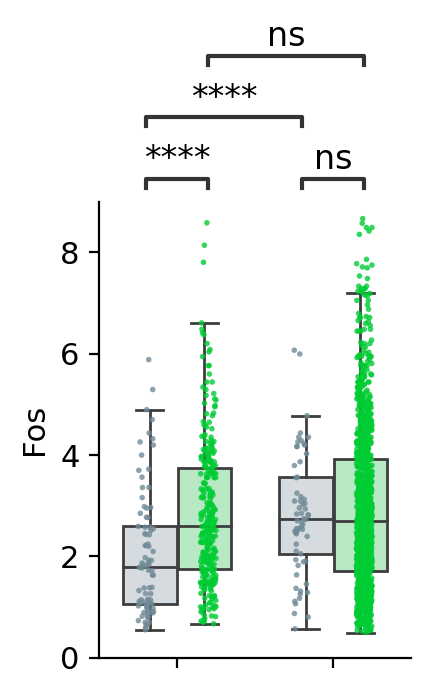

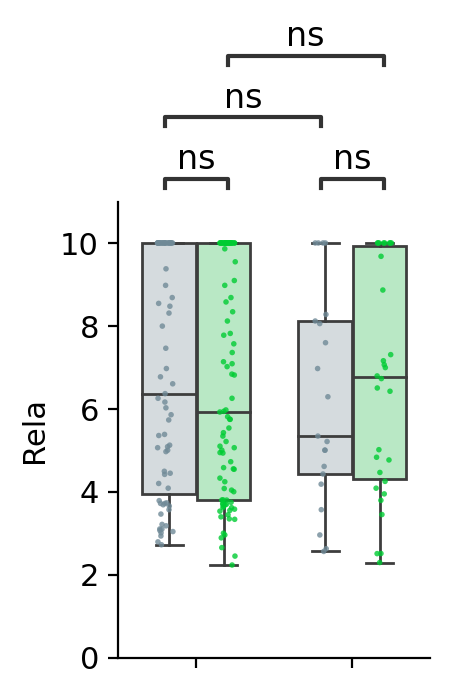

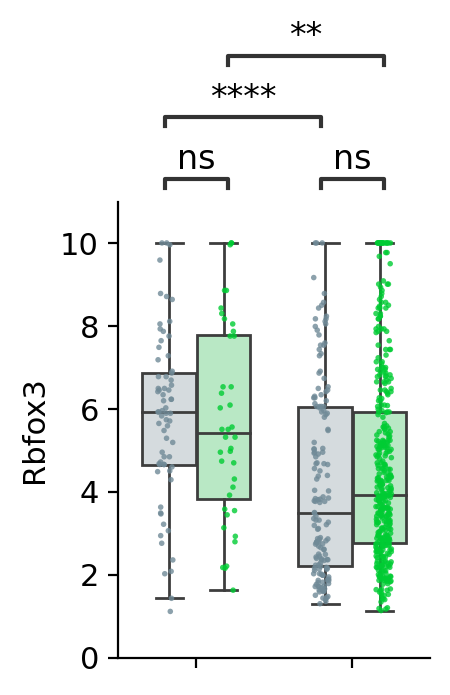

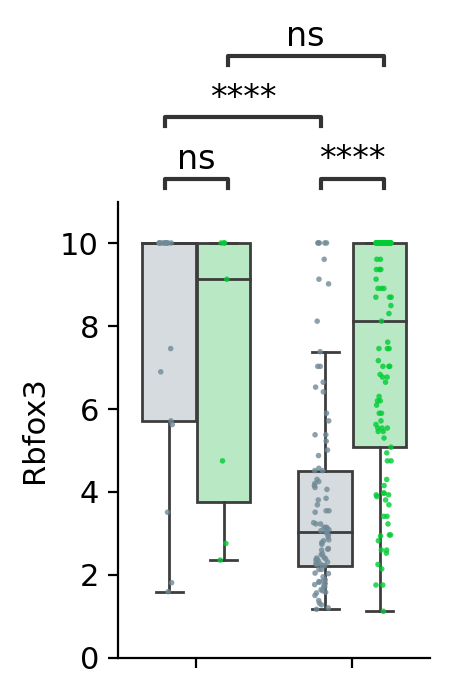

In [29]:
colors = {'PBS':'#708a97', 'KA':'#00CC33'}
boxplot_RNA_by_treatment(ad_PBS, ad_KA, 'Fos', 'cFos', color_dict=colors, 
                         ylims=[0,9], scaling='spliced', desc='spliced')
boxplot_RNA_by_treatment(ad_PBS, ad_KA, 'Rela', 'p65', color_dict=colors, 
                         ylims=[0,11], scaling='spliced', desc='spliced')
boxplot_RNA_by_treatment(ad_PBS, ad_KA, 'Rbfox3', 'NeuN', color_dict=colors, 
                         ylims=[0,11], scaling='spliced', desc='spliced')
boxplot_RNA_by_treatment(ad_PBS, ad_KA, 'Rbfox3', 'NeuN', color_dict=colors, 
                         ylims=[0,11], scaling='unspliced', desc='unspliced')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

on_PBS v.s. on_KA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.284e+03
off_PBS v.s. off_KA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.652e-01 U_stat=7.600e+01
off_PBS v.s. on_PBS: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.783e-01 U_stat=6.200e+01
off_KA v.s. on_KA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.454e-01 U_stat=4.013e+03
Saved figure to analyses/20210414_revision_combined/boxplot_PBSvsKA_cFos_Fos_zscore_non_neurons.pdf
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

on_PBS v.s. on_KA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 

<AxesSubplot:ylabel='Fos'>

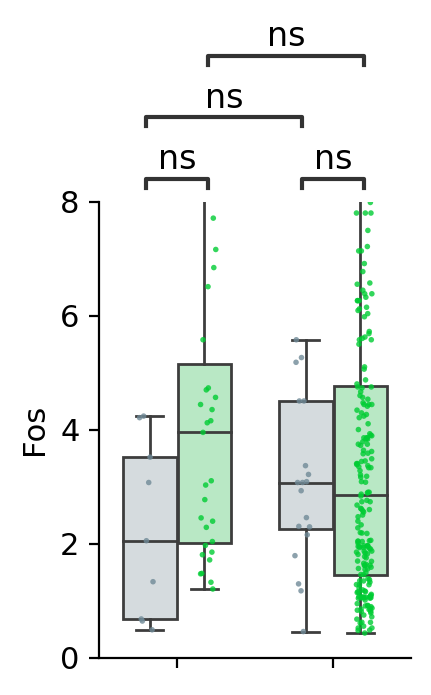

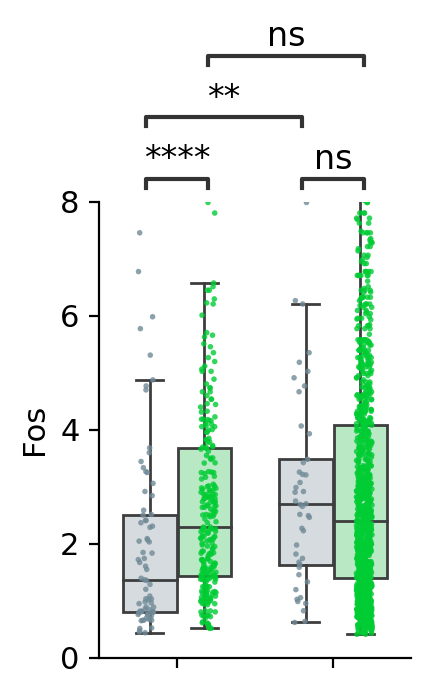

In [30]:
colors = {'PBS':'#708a97', 'KA':'#00CC33'}
boxplot_RNA_by_treatment(ad_non_neur_PBS, ad_non_neur_KA, 'Fos', 'cFos', 
                         color_dict=colors, ylims=[0,8],
                        desc='non_neurons')

boxplot_RNA_by_treatment(ad_neur_PBS, ad_neur_KA, 'Fos', 'cFos', 
                         color_dict=colors, ylims=[0,8],
                        desc='neurons')

## save

In [ ]:
cluster_prot_file = './write/revision_inCITE_subset_annotated.h5ad'
ad_inCITE.write(cluster_prot_file)